# **Estimación de la pose mediante segmentación**

## Autores

* #### Alejandro Torres Rodríguez
* #### Javier Moreno Morón
* #### Ariel Terrón Rosas
* #### Iván Salinas López

# **0. Librerias**

In [ ]:
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *
from fastdownload import FastDownload
from google.colab import drive
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 865.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.6 MB/s eta 0:00:00
Mounted at /content/gdrive
fastcore version 1.5.29 installed
fastai version 2.7.13 installed
Mounted at /content/drive


# **1. Problema a resolver**

En este notebook se recoge el código para la estimación de la pose de una persona mediante la estimación de la posición en la imagen de 16 articulaciones. En este caso, se tratará de realizar la estimación mediante la creación de un mapa de segmentación sintético resultante de crear 16 *heatmaps*, uno por articulación, y juntarlos en una sola imagen asignando a cada articulación una clase distinta (y una clase adicional para el fondo de la imagen). De esta forma se esperan solucionar algunos problemas que plantea la regresión de 32 valores como las coordenadas asociadas a la pose, como que en una imagen del tronco superior no aparezcan las articulaciones inferiores. Usando este enfoque como segmentación, la ausencia de estas articulaciones se espera que se solucione ignorando las clases correspondientes.

# **2. Creación del Dataset**

A continuación se encuentra el código para la descarga de los datos del dataset, así como su filtrado y construcción de un dataframe apropiado para la tarea. También se incluye un apartado donde se crean los objetivos para la segmentación a partir de los datos de coordenadas para las articulaciones, explicado más adelante en su apartado correspondiente.

## **2.1 Descarga de Datos**

In [ ]:
download = False # Controla si se descargan los datos o no

In [ ]:
# Descarga de las imágenes
if download:
    # Cambiamos al directorio local de cada uno
    %cd '/content/drive/MyDrive'

    data_url = 'https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz'

    # Descargamos los datos y los descomprimimos
    # Los datos comprimidos se guardan en fastai/downloaded
    # Los datos descomprimidos se guardan en fastai/extracted
    downloader = FastDownload(base='fastai', archive='downloaded', data='extracted')
    path = downloader.get(data_url, force=True)

    print(path)

    # Volvemos al directorio original
    %cd '/content'

In [ ]:
# Descarga de las anotaciones
if download:
    # Cambiamos al directorio local de cada uno
    %cd '/content/drive/MyDrive'

    data_url = 'https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1_u12_2.zip'

    # Descargamos las anotaciones
    downloader = FastDownload(base='fastai', archive='downloaded', data='extracted')
    path = downloader.get(data_url, force=True)

    print(path)

    # Volvemos al directorio original
    %cd '/content'

## **2.2 Construcción del Dataframe**




Ahora crearemos el conjunto de datos a usar por los modelos. Disponemos de las siguientes 16 articulaciones, nombradas según las anotaciones del dataset:
    'r ankle','r knee','r hip','l hip','l knee','l ankle','pelvis','thorax','upper neck','head top','r wrist','r elbow','r shoulder','l shoulder','l elbow','l wrist'. 
También definimos el tamaño al que escalaremos las imágenes para la entrada del modelo. En este caso, nos restringiremos a imágenes con una sola persona en escena.

In [ ]:
TARGET_IMAGE_SIZE = 256
JOINT_IDS = ['r ankle','r knee','r hip','l hip','l knee','l ankle','pelvis','thorax','upper neck','head top','r wrist','r elbow','r shoulder','l shoulder','l elbow','l wrist']

In [ ]:
datos_matlab = scipy.io.loadmat(
    '/content/drive/MyDrive/fastai/extracted/mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat', \
    struct_as_record=False
)

In [ ]:
release = vars(datos_matlab['RELEASE'][0,0])
annolist = release['annolist'][0]
img_train = release['img_train'][0]
single_person = release['single_person']
actlist = release['act']

In [ ]:
from tqdm import tqdm

nimages = annolist.size
data = pd.DataFrame()

for imgidx in tqdm(range(nimages),total=nimages,desc="Progress"):
  annotation = annolist[imgidx]
  train = img_train[imgidx]
  ridx = single_person[imgidx]
  act = vars(actlist[imgidx,0])

  filename = annotation.image[0,0].name[0]
  act_id = act['act_id'][0,0]

  fila_nueva = { }

  # filename, train and act type

  fila_nueva['file name'] = filename
  fila_nueva['img train'] = train
  fila_nueva['cat name'] = 'NaN'
  fila_nueva['act name'] = 'NaN'
  fila_nueva['act id'] = act_id

  if act_id != -1: fila_nueva['cat name'] = act['cat_name'][0]
  if act_id != -1: fila_nueva['act_name'] = act['act_name'][0]

  # joint data

  for id in JOINT_IDS:
    fila_nueva[id] = 'NaN'

  if annotation.annorect.size > 0: annorect = annotation.annorect[0]
  else: annorect = np.array([])

  if annorect.size == 1 and 'annopoints' in vars(annorect[0]):
    annopoints = annorect[0].annopoints[0,0].point[0]
    for joint in annopoints:
      xcoord = 'NaN'
      ycoord = 'NaN'
      is_visible = 'NaN'
      id = 'NaN'

      if 0 < joint.x.size: xcoord = joint.x[0,0]
      if 0 < joint.y.size: ycoord = joint.y[0,0]
      if 0 < joint.is_visible.size and len(joint.is_visible.shape) == 2: is_visible = joint.is_visible[0,0]
      elif 0 < joint.is_visible.size and len(joint.is_visible.shape) == 1: is_visible = joint.is_visible[0]
      if 0 < joint.id.size: id = JOINT_IDS[joint.id[0,0]]

      if id != 'NaN':
        fila_nueva[id] = (xcoord,ycoord,is_visible)

  data = pd.concat([data, pd.DataFrame([fila_nueva])], ignore_index=True)


Progress: 100%|██████████| 24987/24987 [02:51<00:00, 145.41it/s]


In [ ]:
data

,file name,img train,cat name,act name,act id,r ankle,r knee,r hip,l hip,l knee,l ankle,pelvis,thorax,upper neck,head top,r wrist,r elbow,r shoulder,l shoulder,l elbow,l wrist,act_name
0,037454012.jpg,0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,095071431.jpg,0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,073199394.jpg,0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,059865848.jpg,0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,015601864.jpg,1,sports,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,curling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24982,072772110.jpg,1,transportation,NaN,972,"(562, 617, 1)","(558, 539, 1)","(553, 452, 1)","(511, 458, 1)","(529, 536, 1)","(541, 610, 1)","(532, 455, 1)","(531, 378, 1)","(528.9869, 352.8365, NaN)","(525.0131, 303.1635, NaN)","(558, 411, 0)","(565, 393, 0)","(572, 377, 1)","(490, 378, 1)","(470, 411, 1)","(461, 414, 1)",pushing car
24983,039361034.jpg,1,transportation,NaN,972,"(496, 377, 1)","(466, 322, 1)","(510, 278, 0)","(540, 280, 1)","(558, 331, 1)","(596, 368, 1)","(525, 279, 0)","(454, 252, 0)","(451.3169, 251.4431, NaN)","(403.6831, 241.5569, NaN)","(378, 311, 0)","(404, 288, 1)","(441, 253, 0)","(466, 251, 1)","(436, 293, 1)","(410, 325, 1)",pushing car
24984,084761779.jpg,1,transportation,NaN,972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pushing car
24985,092025825.jpg,0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data = data.loc[data['img train'] == 1]
data = data.reset_index(drop=True)
data

,file name,img train,cat name,act name,act id,r ankle,r knee,r hip,l hip,l knee,l ankle,pelvis,thorax,upper neck,head top,r wrist,r elbow,r shoulder,l shoulder,l elbow,l wrist,act_name
0,015601864.jpg,1,sports,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,curling
1,015599452.jpg,1,sports,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,curling
2,005808361.jpg,1,sports,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,curling
3,086617615.jpg,1,sports,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,curling
4,060111501.jpg,1,sports,NaN,1,"(980, 322, 1)","(896, 318, 0)","(865, 248, 1)","(943, 226, 1)","(948, 290, 1)","(881, 349, 1)","(904, 237, 1)","(858, 135, 1)","(871.1877, 180.4244, NaN)","(835.8123, 58.5756, NaN)","(772, 294, 1)","(754, 247, 1)","(792, 147, 1)","(923, 123, 1)","(995, 163, 0)","(961, 223, 0)",curling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18074,033474347.jpg,1,transportation,NaN,972,"(876, 461, 1)","(815, 380, 1)","(779, 296, 1)","(742, 303, 1)","(706, 386, 1)","(739, 468, 1)","(761, 300, 1)","(684, 219, 0)","(671.7848, 204.2324, NaN)","(629.2152, 152.7676, NaN)","(693, 243, 0)","(726, 260, 0)","(704, 214, 0)","(663, 223, 1)","(674, 286, 1)","(631, 260, 1)",pushing car
18075,082650067.jpg,1,transportation,NaN,972,"(1038, 656, 1)","(950, 504, 1)","(903, 328, 1)","(831, 337, 1)","(811, 504, 1)","(853, 637, 1)","(867, 333, 1)","(775, 212, 0)","(762.9653, 196.7913, NaN)","(696.0347, 112.2087, NaN)","(815, 236, 0)","(864, 273, 0)","(821, 204, 0)","(729, 220, 1)","(704, 332, 1)","(675, 269, 1)",pushing car
18076,072772110.jpg,1,transportation,NaN,972,"(562, 617, 1)","(558, 539, 1)","(553, 452, 1)","(511, 458, 1)","(529, 536, 1)","(541, 610, 1)","(532, 455, 1)","(531, 378, 1)","(528.9869, 352.8365, NaN)","(525.0131, 303.1635, NaN)","(558, 411, 0)","(565, 393, 0)","(572, 377, 1)","(490, 378, 1)","(470, 411, 1)","(461, 414, 1)",pushing car
18077,039361034.jpg,1,transportation,NaN,972,"(496, 377, 1)","(466, 322, 1)","(510, 278, 0)","(540, 280, 1)","(558, 331, 1)","(596, 368, 1)","(525, 279, 0)","(454, 252, 0)","(451.3169, 251.4431, NaN)","(403.6831, 241.5569, NaN)","(378, 311, 0)","(404, 288, 1)","(441, 253, 0)","(466, 251, 1)","(436, 293, 1)","(410, 325, 1)",pushing car


In [ ]:
joint_df = pd.DataFrame()

for _,row in tqdm(data.iterrows(), total=len(data), desc="Progress"):
  new_row = {}
  new_row['file name'] = row['file name']
  for id in JOINT_IDS:
    if row[id] == 'NaN': continue
    x,y,visible = row[id]
    if x < 0.0: x = 0.0
    if y < 0.0: y = 0.0
    if visible == 'NaN': visible = 0
    new_row[id] = (x,y,visible)

  joint_df = pd.concat([joint_df, pd.DataFrame([new_row])], ignore_index=True)

joint_df

Progress: 100%|██████████| 18079/18079 [01:40<00:00, 180.76it/s]


,file name,r ankle,r knee,r hip,l hip,l knee,l ankle,pelvis,thorax,upper neck,head top,r wrist,r elbow,r shoulder,l shoulder,l elbow,l wrist
0,015601864.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,015599452.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,005808361.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,086617615.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,060111501.jpg,"(980, 322, 1)","(896, 318, 0)","(865, 248, 1)","(943, 226, 1)","(948, 290, 1)","(881, 349, 1)","(904, 237, 1)","(858, 135, 1)","(871.1877, 180.4244, 0)","(835.8123, 58.5756, 0)","(772, 294, 1)","(754, 247, 1)","(792, 147, 1)","(923, 123, 1)","(995, 163, 0)","(961, 223, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18074,033474347.jpg,"(876, 461, 1)","(815, 380, 1)","(779, 296, 1)","(742, 303, 1)","(706, 386, 1)","(739, 468, 1)","(761, 300, 1)","(684, 219, 0)","(671.7848, 204.2324, 0)","(629.2152, 152.7676, 0)","(693, 243, 0)","(726, 260, 0)","(704, 214, 0)","(663, 223, 1)","(674, 286, 1)","(631, 260, 1)"
18075,082650067.jpg,"(1038, 656, 1)","(950, 504, 1)","(903, 328, 1)","(831, 337, 1)","(811, 504, 1)","(853, 637, 1)","(867, 333, 1)","(775, 212, 0)","(762.9653, 196.7913, 0)","(696.0347, 112.2087, 0)","(815, 236, 0)","(864, 273, 0)","(821, 204, 0)","(729, 220, 1)","(704, 332, 1)","(675, 269, 1)"
18076,072772110.jpg,"(562, 617, 1)","(558, 539, 1)","(553, 452, 1)","(511, 458, 1)","(529, 536, 1)","(541, 610, 1)","(532, 455, 1)","(531, 378, 1)","(528.9869, 352.8365, 0)","(525.0131, 303.1635, 0)","(558, 411, 0)","(565, 393, 0)","(572, 377, 1)","(490, 378, 1)","(470, 411, 1)","(461, 414, 1)"
18077,039361034.jpg,"(496, 377, 1)","(466, 322, 1)","(510, 278, 0)","(540, 280, 1)","(558, 331, 1)","(596, 368, 1)","(525, 279, 0)","(454, 252, 0)","(451.3169, 251.4431, 0)","(403.6831, 241.5569, 0)","(378, 311, 0)","(404, 288, 1)","(441, 253, 0)","(466, 251, 1)","(436, 293, 1)","(410, 325, 1)"


In [ ]:
for i,row in tqdm(joint_df.iterrows(), total=len(joint_df), desc="Progress"):
  drop = True
  for id in JOINT_IDS:
    if not pd.isna(row[id]):
      drop = False
      break

  if drop: joint_df = joint_df.drop(i)

joint_df = joint_df.reset_index(drop=True)
joint_df

Progress: 100%|██████████| 18079/18079 [00:35<00:00, 505.58it/s]


,file name,r ankle,r knee,r hip,l hip,l knee,l ankle,pelvis,thorax,upper neck,head top,r wrist,r elbow,r shoulder,l shoulder,l elbow,l wrist
0,060111501.jpg,"(980, 322, 1)","(896, 318, 0)","(865, 248, 1)","(943, 226, 1)","(948, 290, 1)","(881, 349, 1)","(904, 237, 1)","(858, 135, 1)","(871.1877, 180.4244, 0)","(835.8123, 58.5756, 0)","(772, 294, 1)","(754, 247, 1)","(792, 147, 1)","(923, 123, 1)","(995, 163, 0)","(961, 223, 0)"
1,002058449.jpg,"(918, 456, 1)","(659, 518, 1)","(713, 413, 1)","(979, 288, 1)","(1222, 453, 1)","(974, 399, 0)","(846, 351, 1)","(738, 259, 1)","(795.2738, 314.8937, 0)","(597.7262, 122.1063, 0)","(441, 490, 1)","(446, 434, 1)","(599, 270, 1)","(877, 247, 1)","(1112, 384, 1)","(1012, 489, 1)"
2,029122914.jpg,NaN,"(301, 473, 1)","(302, 346, 1)","(362, 345, 1)","(367, 470, 1)",NaN,"(332, 346, 1)","(325, 217, 1)","(326.2681, 196.1669, 0)","(330.7319, 122.8331, 0)","(275, 299, 1)","(262, 300, 1)","(278, 220, 1)","(371, 213, 1)","(396, 309, 1)","(393, 290, 1)"
3,061185289.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(533, 322, 0)","(515.0945, 277.1333, 0)","(463.9055, 148.8667, 0)","(353, 172, 1)","(426, 239, 1)","(513, 288, 0)","(552, 355, 1)",NaN,NaN
4,013949386.jpg,NaN,NaN,"(110, 385, 1)","(208, 355, 1)",NaN,NaN,"(159, 370, 1)","(189, 228, 1)","(191.1195, 227.0916, 0)","(326.8805, 168.9084, 0)","(367, 363, 1)","(254, 429, 1)","(166, 303, 1)","(212, 153, 1)","(319, 123, 1)","(376, 39, 1)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11426,050240222.jpg,"(607, 689, 1)","(599, 542, 0)","(605, 416, 0)","(691, 410, 1)","(704, 555, 1)","(714, 704, 1)","(648, 413, 0)","(599, 230, 1)","(595.1375, 204.3532, 0)","(577.8625, 89.6468, 0)","(418, 305, 0)","(472, 281, 1)","(534, 232, 1)","(663, 228, 1)","(623, 289, 1)","(555, 333, 1)"
11427,033474347.jpg,"(876, 461, 1)","(815, 380, 1)","(779, 296, 1)","(742, 303, 1)","(706, 386, 1)","(739, 468, 1)","(761, 300, 1)","(684, 219, 0)","(671.7848, 204.2324, 0)","(629.2152, 152.7676, 0)","(693, 243, 0)","(726, 260, 0)","(704, 214, 0)","(663, 223, 1)","(674, 286, 1)","(631, 260, 1)"
11428,082650067.jpg,"(1038, 656, 1)","(950, 504, 1)","(903, 328, 1)","(831, 337, 1)","(811, 504, 1)","(853, 637, 1)","(867, 333, 1)","(775, 212, 0)","(762.9653, 196.7913, 0)","(696.0347, 112.2087, 0)","(815, 236, 0)","(864, 273, 0)","(821, 204, 0)","(729, 220, 1)","(704, 332, 1)","(675, 269, 1)"
11429,072772110.jpg,"(562, 617, 1)","(558, 539, 1)","(553, 452, 1)","(511, 458, 1)","(529, 536, 1)","(541, 610, 1)","(532, 455, 1)","(531, 378, 1)","(528.9869, 352.8365, 0)","(525.0131, 303.1635, 0)","(558, 411, 0)","(565, 393, 0)","(572, 377, 1)","(490, 378, 1)","(470, 411, 1)","(461, 414, 1)"


## **2.3 Creación de las imágenes de segmentación**

Para la creación de los objetivos para entrenar el modelo se ha seguido el siguiente procedimiento:
    - Para cada articulación presente en la imagen, crear un mapa de calor. De estas forma se obtienen hasta 16 mapas de calor por imagen.
    - Con los mapas de calor obtenidos, superponerlos en una sola imagen asignado una clase distinta a cada uno de los mapas.

En las celdas inferiores se puede observar una imagen de ejemplo y la segmentación asociada.

Respecto a los datos, cabe destacar la presencia de cuatro outliers, imágenes que aparecen como títulos en la columna 'file names' del conjunto de datos pero que no están presentes en el conjunto real de imágenes. Estas entradas serán eliminadas.

In [ ]:
from scipy.stats import multivariate_normal

SEGMENTATION_COLORS = [
    ('Red', (255, 0, 0)),
    ('Green', (0, 255, 0)),
    ('Blue', (0, 0, 255)),
    ('Yellow', (255, 255, 0)),
    ('Purple', (128, 0, 128)),
    ('Orange', (255, 165, 0)),
    ('Cyan', (0, 255, 255)),
    ('Magenta', (255, 0, 255)),
    ('Lime', (0, 255, 0)),
    ('Pink', (255, 182, 193)),
    ('Teal', (0, 128, 128)),
    ('Lavender', (230, 230, 250)),
    ('Brown', (165, 42, 42)),
    ('Maroon', (128, 0, 0)),
    ('Olive', (128, 128, 0)),
    ('Coral', (255, 127, 80))
]

def create_heatmap(image_shape, center, sigma=1.0):
    x, y = np.meshgrid(np.arange(0, image_shape[1]), np.arange(0, image_shape[0]))
    pos = np.dstack((x, y))

    rv = multivariate_normal(mean=center, cov=[[sigma, 0], [0, sigma]])
    heatmap = rv.pdf(pos)

    heatmap = heatmap / np.max(heatmap)

    return heatmap

def create_segmentation_target(shape,coords,sigma=1.0):
  target = np.zeros(shape,dtype=np.uint8)

  for i,id in enumerate(JOINT_IDS):
    if id in coords:
      x,y = coords[id]
      heatmap = create_heatmap(shape,(x,y),sigma=sigma)
      target = np.where(heatmap > 0.5,i+1,target)


  return target

def colorize_segmentation_image(image,colors=SEGMENTATION_COLORS):
  colorized = np.zeros((image.shape[0],image.shape[1],3),np.uint8)
  masks = []

  for i,id in enumerate(JOINT_IDS):
    masks.append(image == i+1)

  for (_,color),mask in zip(colors,masks):
    colorized[...,0][mask] = color[0]
    colorized[...,1][mask] = color[1]
    colorized[...,2][mask] = color[2]

  return colorized

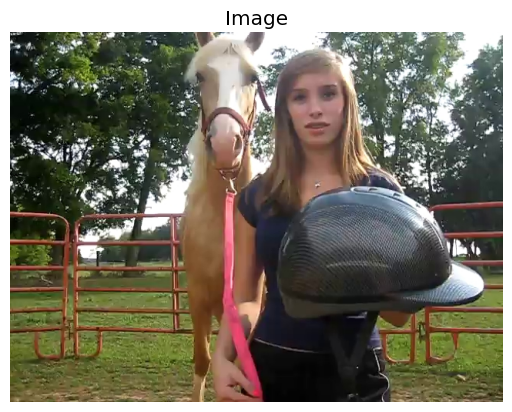

In [ ]:
image_path = '/content/drive/MyDrive/fastai/extracted/mpii_human_pose_v1/'

sample_row = data.loc[100]
sample_file_name = sample_row['file name']
sample_image = cv2.cvtColor(cv2.imread(image_path + sample_file_name),cv2.COLOR_BGR2RGB)

plt.imshow(sample_image)
plt.title("Image")
plt.axis("off")
plt.show()

16
255


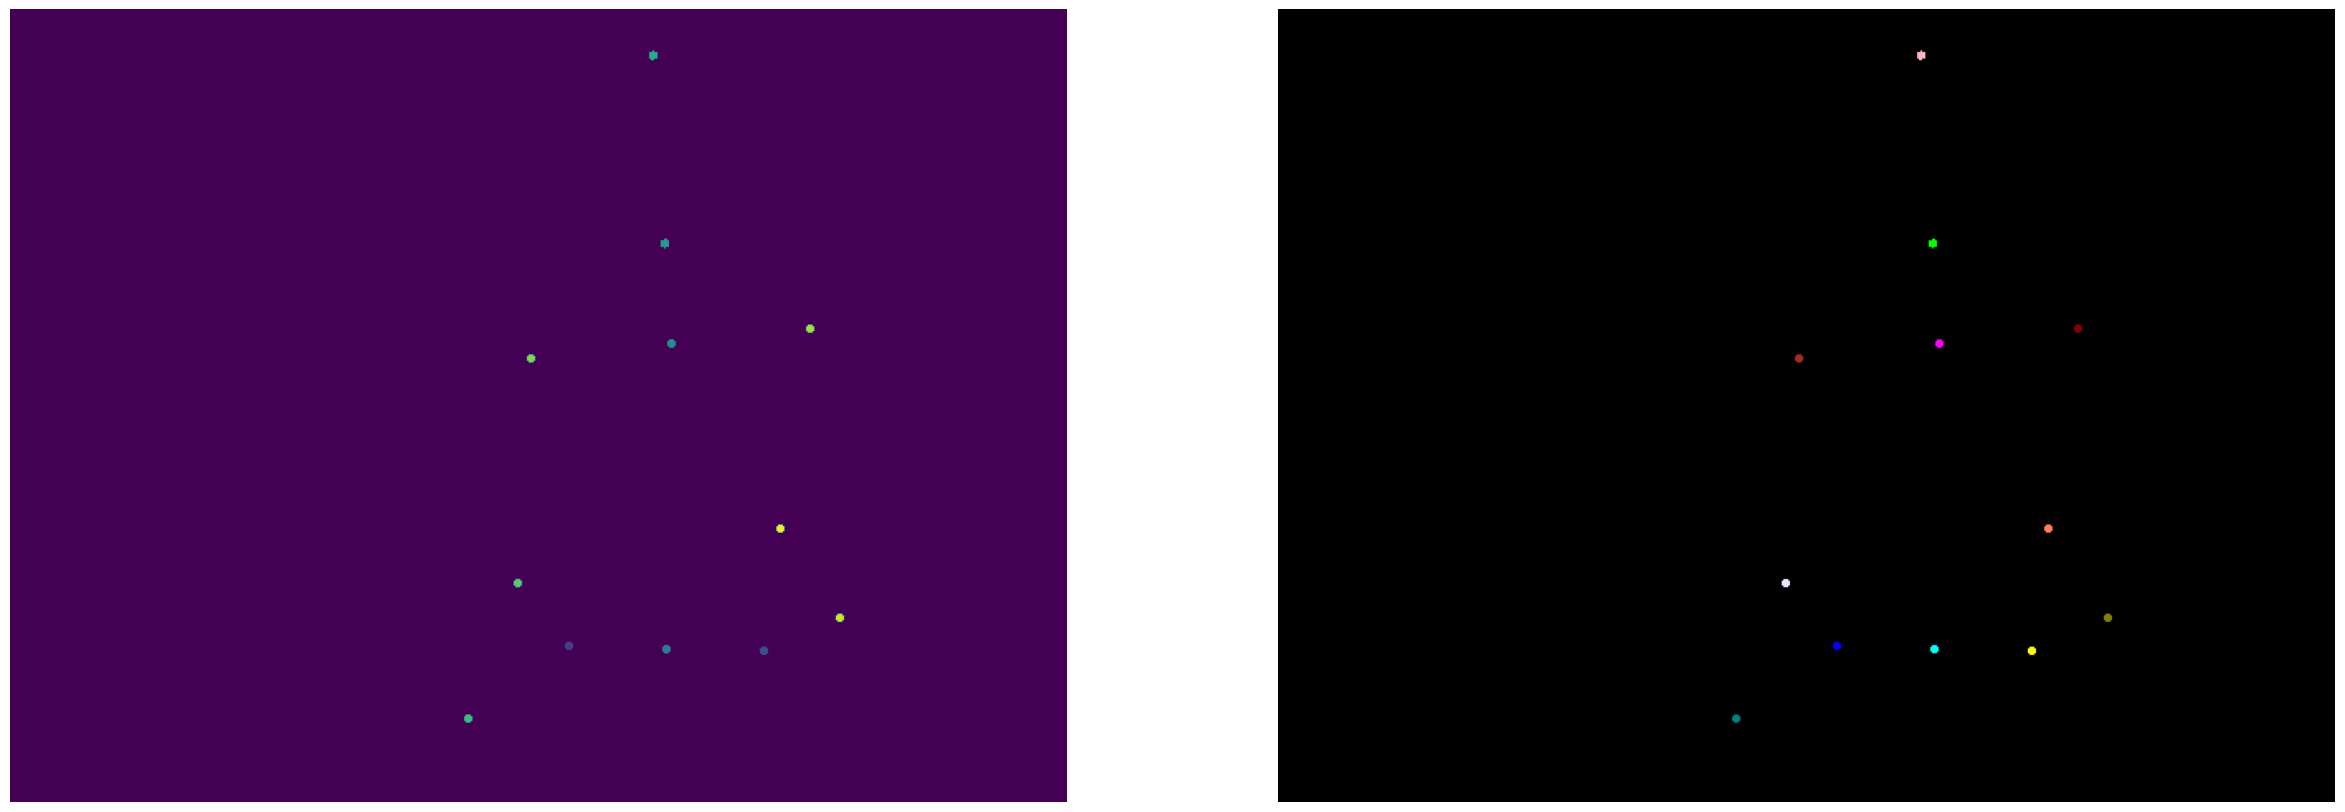

In [ ]:
sample_joint_coords = {}

for id in JOINT_IDS:
  if sample_row[id] == 'NaN': continue
  x,y,visible = sample_row[id]
  sample_joint_coords[id] = (x,y)

sample_target = create_segmentation_target(sample_image.shape[:2],sample_joint_coords,sigma=5.0)
colorized_target = colorize_segmentation_image(sample_target)

print(sample_target.max())
print(colorized_target.max())

plt.figure(figsize=(30,15))

plt.subplot(1,2,1)
plt.imshow(sample_target)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(colorized_target)
plt.axis('off')

plt.show()

Esta parte del código crea los objetivos para la segmentación y guarda las imágenes para su posterior uso. Se incluye una variable booleana (desactivada por defecto) ya que es un proceso lento y que consume memoria.

In [ ]:
create_synthetic_segmentation_targets = False

In [ ]:
import concurrent.futures
from itertools import islice

target_path = '/content/drive/MyDrive/fastai/extracted/targets/'
image_path = '/content/drive/MyDrive/fastai/extracted/mpii_human_pose_v1/'

def process_row(row_tuple):
  try:
      _, row = row_tuple
      filename = row['file name']
      name, _ = os.path.splitext(filename)

      image = cv2.imread(image_path + filename)

      if image is None:
          tqdm.write(f"Error reading image: {filename}")
          return

      joint_coords = {}

      for joint_id in JOINT_IDS:
          if pd.isna(row[joint_id]) or row[joint_id] == 'NaN':
              continue
          x, y, visible = row[joint_id]
          joint_coords[joint_id] = (x, y)

      segmentation_target = create_segmentation_target(image.shape[:2], joint_coords, sigma=5.0)
      cv2.imwrite(target_path + name + '.png', segmentation_target)

  except Exception as e:
        tqdm.write(f"Error processing row: {str(e)}")

if create_synthetic_segmentation_targets:
  rows_to_process = islice(joint_df.iterrows(), 6626, None)

  with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
      for _ in tqdm(executor.map(process_row, rows_to_process), total=len(joint_df), desc="Progress"):
          pass

In [ ]:
for filename in joint_df['file name']:
  name, ext = os.path.splitext(filename)

  impath = image_path + name + ext
  targetpath = target_path + name + '.png'

  exists_in_path1 = os.path.exists(impath)
  exists_in_path2 = os.path.exists(targetpath)

  if not (exists_in_path1 and exists_in_path2):
    print(f'error in file: {filename}')
    joint_df = joint_df.loc[joint_df['file name'] != filename]

joint_df = joint_df.reset_index(drop=True)
joint_df

error in file: 015663418.jpg
error in file: 088058244.jpg
error in file: 060683143.jpg
error in file: 071260468.jpg


,file name,r ankle,r knee,r hip,l hip,l knee,l ankle,pelvis,thorax,upper neck,head top,r wrist,r elbow,r shoulder,l shoulder,l elbow,l wrist
0,060111501.jpg,"(980, 322, 1)","(896, 318, 0)","(865, 248, 1)","(943, 226, 1)","(948, 290, 1)","(881, 349, 1)","(904, 237, 1)","(858, 135, 1)","(871.1877, 180.4244, 0)","(835.8123, 58.5756, 0)","(772, 294, 1)","(754, 247, 1)","(792, 147, 1)","(923, 123, 1)","(995, 163, 0)","(961, 223, 0)"
1,002058449.jpg,"(918, 456, 1)","(659, 518, 1)","(713, 413, 1)","(979, 288, 1)","(1222, 453, 1)","(974, 399, 0)","(846, 351, 1)","(738, 259, 1)","(795.2738, 314.8937, 0)","(597.7262, 122.1063, 0)","(441, 490, 1)","(446, 434, 1)","(599, 270, 1)","(877, 247, 1)","(1112, 384, 1)","(1012, 489, 1)"
2,029122914.jpg,NaN,"(301, 473, 1)","(302, 346, 1)","(362, 345, 1)","(367, 470, 1)",NaN,"(332, 346, 1)","(325, 217, 1)","(326.2681, 196.1669, 0)","(330.7319, 122.8331, 0)","(275, 299, 1)","(262, 300, 1)","(278, 220, 1)","(371, 213, 1)","(396, 309, 1)","(393, 290, 1)"
3,061185289.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(533, 322, 0)","(515.0945, 277.1333, 0)","(463.9055, 148.8667, 0)","(353, 172, 1)","(426, 239, 1)","(513, 288, 0)","(552, 355, 1)",NaN,NaN
4,013949386.jpg,NaN,NaN,"(110, 385, 1)","(208, 355, 1)",NaN,NaN,"(159, 370, 1)","(189, 228, 1)","(191.1195, 227.0916, 0)","(326.8805, 168.9084, 0)","(367, 363, 1)","(254, 429, 1)","(166, 303, 1)","(212, 153, 1)","(319, 123, 1)","(376, 39, 1)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11422,050240222.jpg,"(607, 689, 1)","(599, 542, 0)","(605, 416, 0)","(691, 410, 1)","(704, 555, 1)","(714, 704, 1)","(648, 413, 0)","(599, 230, 1)","(595.1375, 204.3532, 0)","(577.8625, 89.6468, 0)","(418, 305, 0)","(472, 281, 1)","(534, 232, 1)","(663, 228, 1)","(623, 289, 1)","(555, 333, 1)"
11423,033474347.jpg,"(876, 461, 1)","(815, 380, 1)","(779, 296, 1)","(742, 303, 1)","(706, 386, 1)","(739, 468, 1)","(761, 300, 1)","(684, 219, 0)","(671.7848, 204.2324, 0)","(629.2152, 152.7676, 0)","(693, 243, 0)","(726, 260, 0)","(704, 214, 0)","(663, 223, 1)","(674, 286, 1)","(631, 260, 1)"
11424,082650067.jpg,"(1038, 656, 1)","(950, 504, 1)","(903, 328, 1)","(831, 337, 1)","(811, 504, 1)","(853, 637, 1)","(867, 333, 1)","(775, 212, 0)","(762.9653, 196.7913, 0)","(696.0347, 112.2087, 0)","(815, 236, 0)","(864, 273, 0)","(821, 204, 0)","(729, 220, 1)","(704, 332, 1)","(675, 269, 1)"
11425,072772110.jpg,"(562, 617, 1)","(558, 539, 1)","(553, 452, 1)","(511, 458, 1)","(529, 536, 1)","(541, 610, 1)","(532, 455, 1)","(531, 378, 1)","(528.9869, 352.8365, 0)","(525.0131, 303.1635, 0)","(558, 411, 0)","(565, 393, 0)","(572, 377, 1)","(490, 378, 1)","(470, 411, 1)","(461, 414, 1)"


# **3. Entrenamiento**

En este apartado se incluye el código referente a la creación del modelo de aprendizaje y su entrenamiento.

In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

## **3.1 Creación del datablock**

Para la creación del datablock usaremos la funcionalidad SegmentationDataLoaders de fastai. Los códigos de las clases serán los nombres de las articulaciones más uno adicional para el fondo. En cuanto las transformaciones, usaremos la normalización con las estadísticas de ImageNet.

In [ ]:
image_path = '/content/drive/MyDrive/fastai/extracted/mpii_human_pose_v1/'
target_path = '/content/drive/MyDrive/fastai/extracted/targets/'

batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

fnames = [ image_path + filename for filename in joint_df['file name'] ]

def label_func(filename):
  base_name = os.path.basename(filename)
  name, _ = os.path.splitext(base_name)
  return os.path.join(target_path, name + '.png')

codes = ['Background'] + JOINT_IDS

dls = SegmentationDataLoaders.from_label_func(image_path, fnames, label_func, codes=codes, item_tfms=Resize(TARGET_IMAGE_SIZE),batch_tfms=batch_tfms, bs=32)

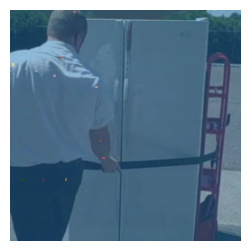

In [ ]:
dls.show_batch(nrows=1,ncols=1)

## **3.2 Creación del modelo y entrenamiento**

Como modelo de entrenamiento usaremos U-Net usando como base el modelo preentrenado de ResNet34. De esta forma esperamos que las conexiones de las primeras capas a las últimas capas mantengan la información espacial y ayuden a predecir la pose.

Como función de pérdida usaremos DiceLoss para clasificar los píxeles en 17 clases, siendo la 0 la asignada para el fondo y las clases 1 a 16 las correspondientes con las articulaciones.

In [ ]:
learner = unet_learner(dls, models.resnet34, loss_func=DiceLoss(), y_range=(0,len(JOINT_IDS)))
learner.summary()

DynamicUnet (Input shape: 32 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 128 x 128 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 64 x 64   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                     

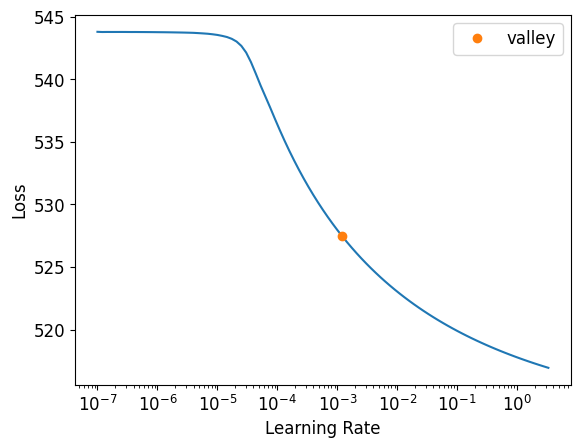

In [ ]:
lr = learner.lr_find().valley

In [ ]:
learner.fine_tune(epochs=2, base_lr=lr, freeze_epochs=1)

epoch,train_loss,valid_loss,time
0,512.006165,510.269745,07:33


epoch,train_loss,valid_loss,time
0,511.994110,510.269745,07:39
1,511.993500,510.269745,07:41


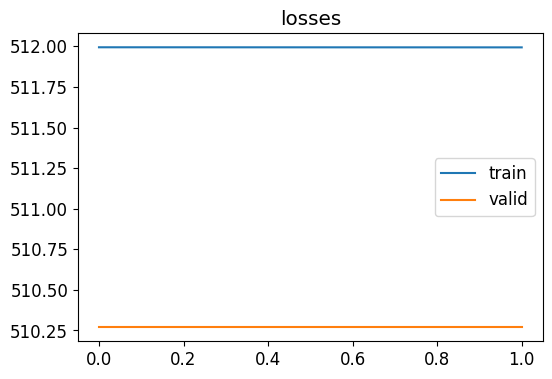

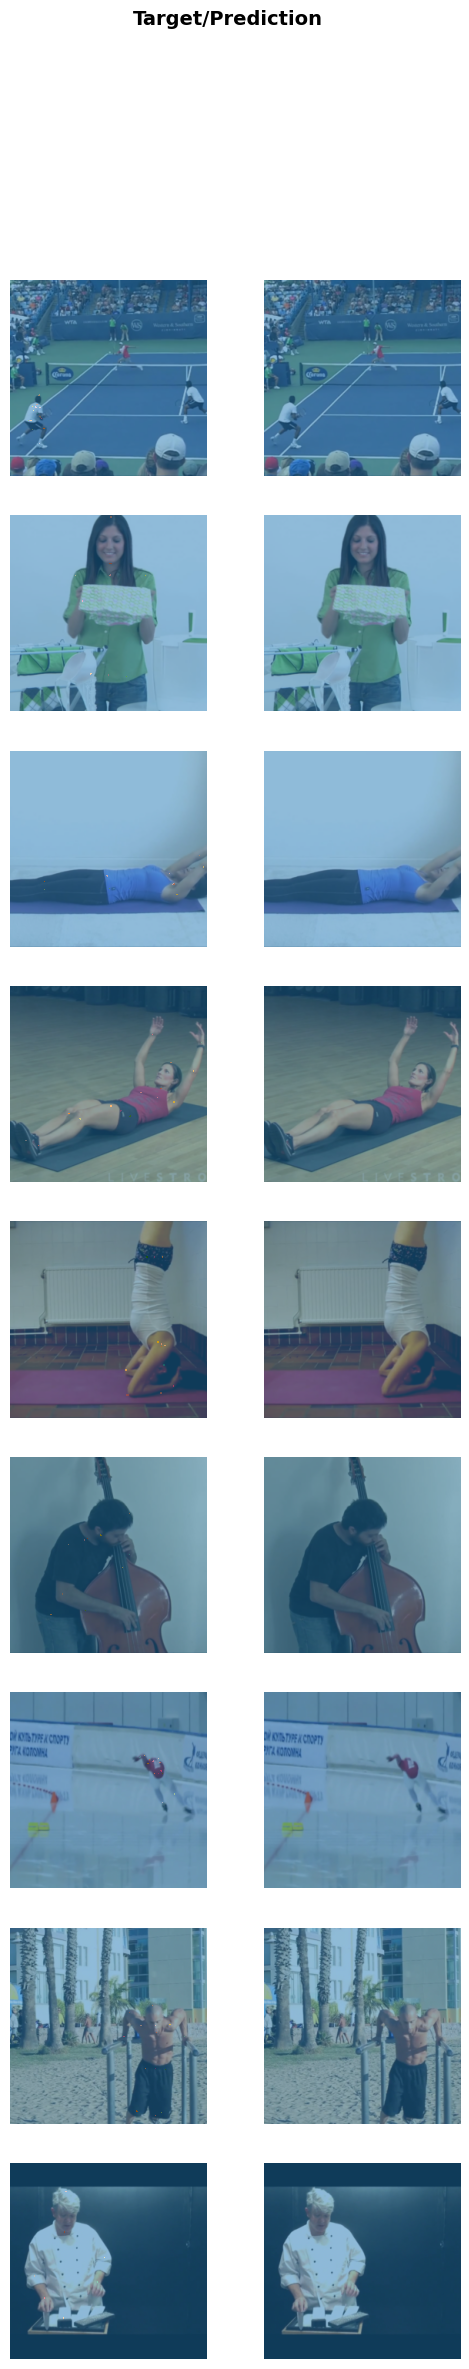

In [ ]:
learner.recorder.plot_metrics()
learner.show_results()

## **4. Resultados**

### **4.1 Curvas de aprendizaje y entrenamiento**


Observando las curvas de aprendizaje obtenidas en el apartado anterior vemos que el entrenamiento no está funcionando. Si bien hemos usado tan solo dos épocas, vemos que el modelo no aprende de una época a la siguiente, manteniendo exactamente el mismo rendimiento. Esto nos indica que algo no funciona en el acercamiento al problema. 

Ademas, si observamos las salidas de los resultados del entrenamiento vemos que el modelo clasifica todo como fondo.

### **4.2 Conclusiones generales**

A la vista de los resultados tempranos en entrenamiento, se observa que el modelo entrenado no es efectivo ya que clasifica todos los píxeles de la imagen como fondo. Aunque esto puede ser un problema común en segmentación, en este caso es especialmente acusado. Los motivos de este comportamiento en el experimento pueden ser diversos, siendo los más probables la falta de píxeles de las distintas clases en cada imagen o que los píxeles generados, al ser un radio alrededor de un punto, sean poco representativos del objeto o articulación al que hacen referencia. Si observamos las imagenes de objetivo, vemos que los puntos de las articulaciones son exesivamente pequeños, lo cual puede ser el motivo de que el modelo no pueda aprender.

A la vista de este experimento, se considera que este acercamiento al problema no es eficaz y no conducirá a buenos resultados, por lo que se omite su prueba en el conjunto de test o el refinamiento entrenando durante más épocas.